# LOCAL UPDATING OF MESHED GEOMODELS AND FLOW SIMULATION


To run a cell, Press Shift+Enter

In [1]:
from lib_distance.Signed_Distance_function import SDF
from lib_cavity.write_local_mesh_file import build_2_local_meshes, merge
from lib_cavity.mesh_2d_file import write_2D_mesh_file_gmsh, write_2D_mesh_file
from read_write_vtk import write_vtk_sol
from mmg2d import mmg2d
import matplotlib.cm as cmap
import matplotlib.colors as col
import meshio
import matplotlib.pyplot as plt
import vtk
import numpy as np
import os
path = os.getcwd()
mmg_path = "/home/legentil/Programmation/ringlab/third_parties/mmg/build/bin/mmg2d_O3"

# Local Updating
The model which is used in this training is a synthetic model of an oil reservoir. To support wave simulations, this model is triangulated, and the proposed method is based on this initial triangle mesh.
The model which is used in this paper is a synthetic model of an oil reservoir in an anticline. The top (violet) and bottom (green) layers are composed of shale, the reservoir rock (blue) is a sandstone. After the insertion of the fracture, a new zone is represented in yellow.
In this training, settings have been chosen to use a mesh with a lower density in order to reduce the computational costs. Parameters will be explained and range values will be advised.


## Provide input paraters for the local upadting

### Provide the geomodel and the fracture information to compute Signed Distance Function


In [2]:
my_mesh = "input_mesh"
my_mesh_path = path + "/data_paper/"+ my_mesh + ".mesh"
output_sol_file_path = path + "/data_paper/gas_water.sol"
#print(path)


In [3]:
mmg2d([mmg_path,"-nomove", "-noinsert", "-noswap",
           my_mesh_path, path + "/data_paper/"+ my_mesh +".vtk"])
vtk_filepath_to_read= path + "/data_paper/"+ my_mesh +".vtk"
vtk_filepath_to_write= path + "/data_paper/"+ my_mesh +"_sol.vtk"

write_vtk_sol(vtk_filepath_to_read, output_sol_file_path, vtk_filepath_to_write)


WRITING COMPLETED


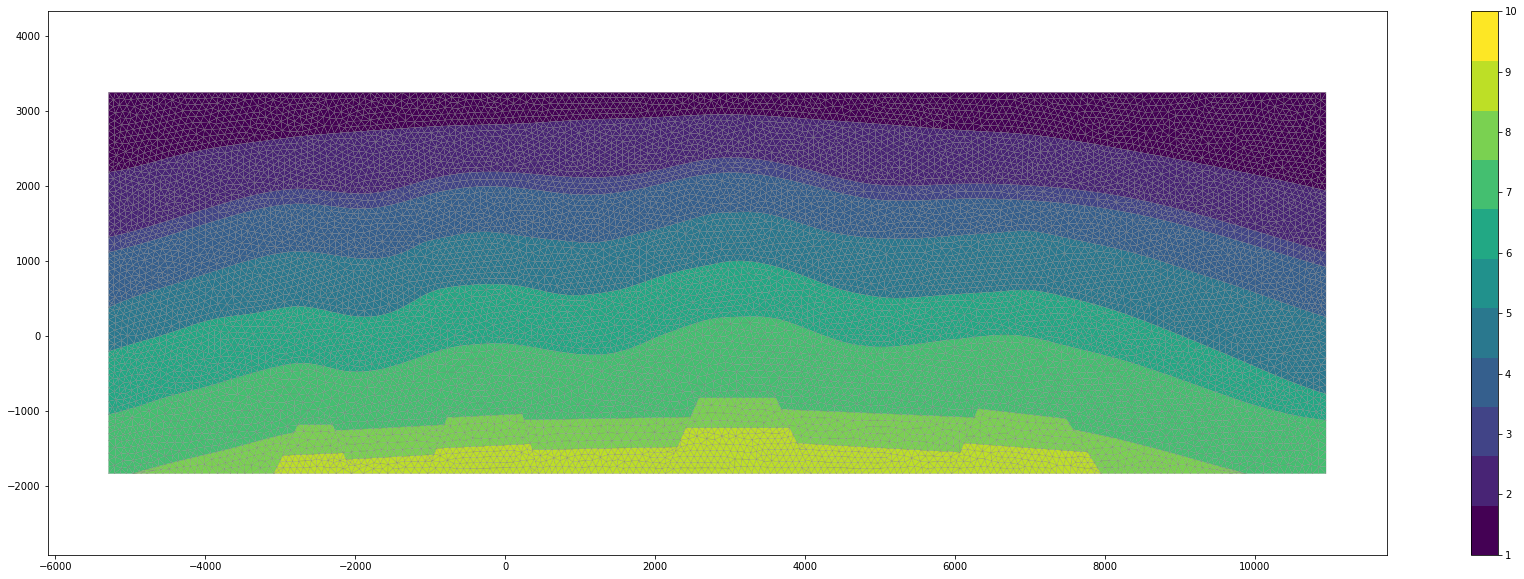

In [4]:
m = meshio.Mesh.read(vtk_filepath_to_write, "vtk")
f=plt.figure(figsize=(30,10))   
a0 = plt.subplot(111)
a0.axis('equal')
# # Read VTK mesh and saturation data
x,y,Triangles=m.points[:,0],m.points[:,1],m.cells_dict['triangle']
region=m.cell_data['medit:ref'][1]
cmap=plt.get_cmap("viridis", 11)
#bounds = np.linspace(1,10,10)
cm=plt.tripcolor(x,y, Triangles,facecolors=region,edgecolor="grey", cmap = cmap)       
     
plt.colorbar(cm)
plt.clim(1,10)



### Visualisation of the fracture implicitly defined at the 0 iso-value of the Signed Distance Function

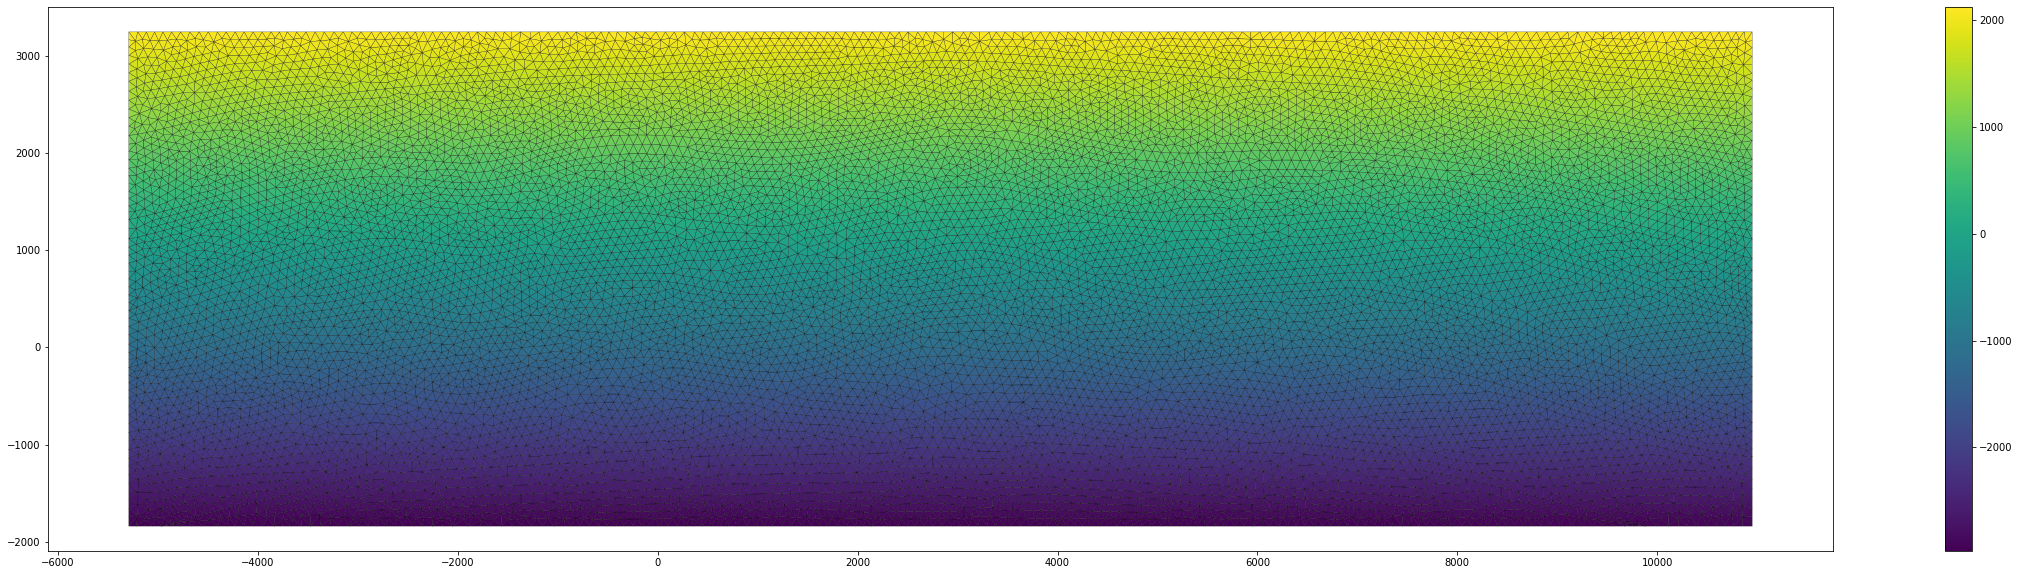

In [6]:
m = meshio.Mesh.read(vtk_filepath_to_write, "vtk")
f=plt.figure(figsize=(40,10))  
    
x,y,Triangles=m.points[:,0],m.points[:,1],m.cells_dict['triangle']
region=m.point_data['Distance']
# plt.tripcolor(x,y, Triangles,facecolors=region)       
cm=plt.tripcolor(x,y, Triangles,region,edgecolor="k")       
plt.colorbar(cm)

## Level-set discretisation with MMG

In [7]:
depth = str(-670)

mmg2d([mmg_path, "-sol", output_sol_file_path, "-ls", depth, "-nomove", "-noinsert", "-noswap",
           my_mesh_path])

output_mesh_file_ls = path + "/data_paper/"+ my_mesh + ".o.mesh"
output_mesh_file_ls_vtk = path + "/data_paper/"+ my_mesh + "_ls.vtk"

mmg2d([mmg_path,"-nomove", "-noinsert", "-noswap",
           output_mesh_file_ls, output_mesh_file_ls_vtk])

WRITING COMPLETED
WRITING COMPLETED


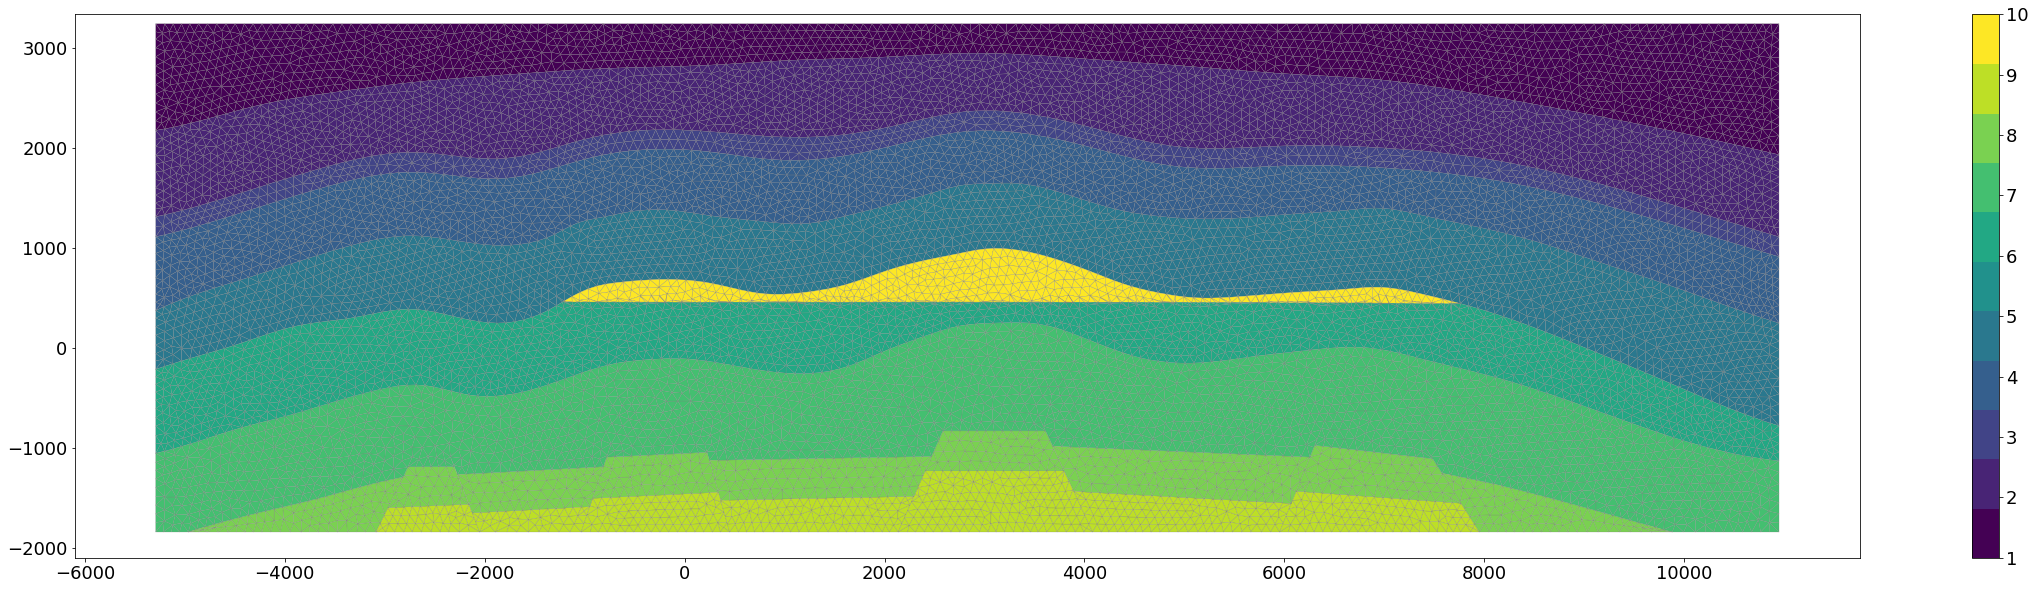

In [8]:
m = meshio.Mesh.read(output_mesh_file_ls_vtk, "vtk")
f=plt.figure(figsize=(40,10)) 
plt.rc('font', size=18)
a0 = plt.subplot(111)
a0.axis('equal')
a0.set_ylim((-2000, 3247))
x,y,Triangles=m.points[:,0],m.points[:,1],m.cells_dict['triangle']
region=m.cell_data['medit:ref'][1]

cm=plt.tripcolor(x,y, Triangles,facecolors=region,edgecolor="grey", cmap=cmap)       
   
plt.colorbar(cm)
plt.clim(1,10)


## Mesh Improvement with MMG

### Definition of the region to modified

In [9]:
#filepath_to_read = output_mesh_file_ls
filepath_to_write_cut = path + "/data_paper/"+ my_mesh + "_reg_cut.mesh"
modified_regions = [6, 10]
kept_regions = [1, 2, 3, 4, 5, 7, 8, 9]
filepath_to_write_other = path + "/data_paper/"+ my_mesh + "_reg_other.mesh"

build_2_local_meshes(output_mesh_file_ls, filepath_to_write_cut, filepath_to_write_other, [modified_regions, kept_regions])

11.852372646331787
[-5291.109375   -1837.56298828     0.         ...   936.64471044
   470.48438594     0.        ]


/home/legentil/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/ctypeslib.py:521: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


[-5291.109375   -1837.56298828     0.         ...   936.64471044
   470.48438594     0.        ]


WRITING COMPLETED


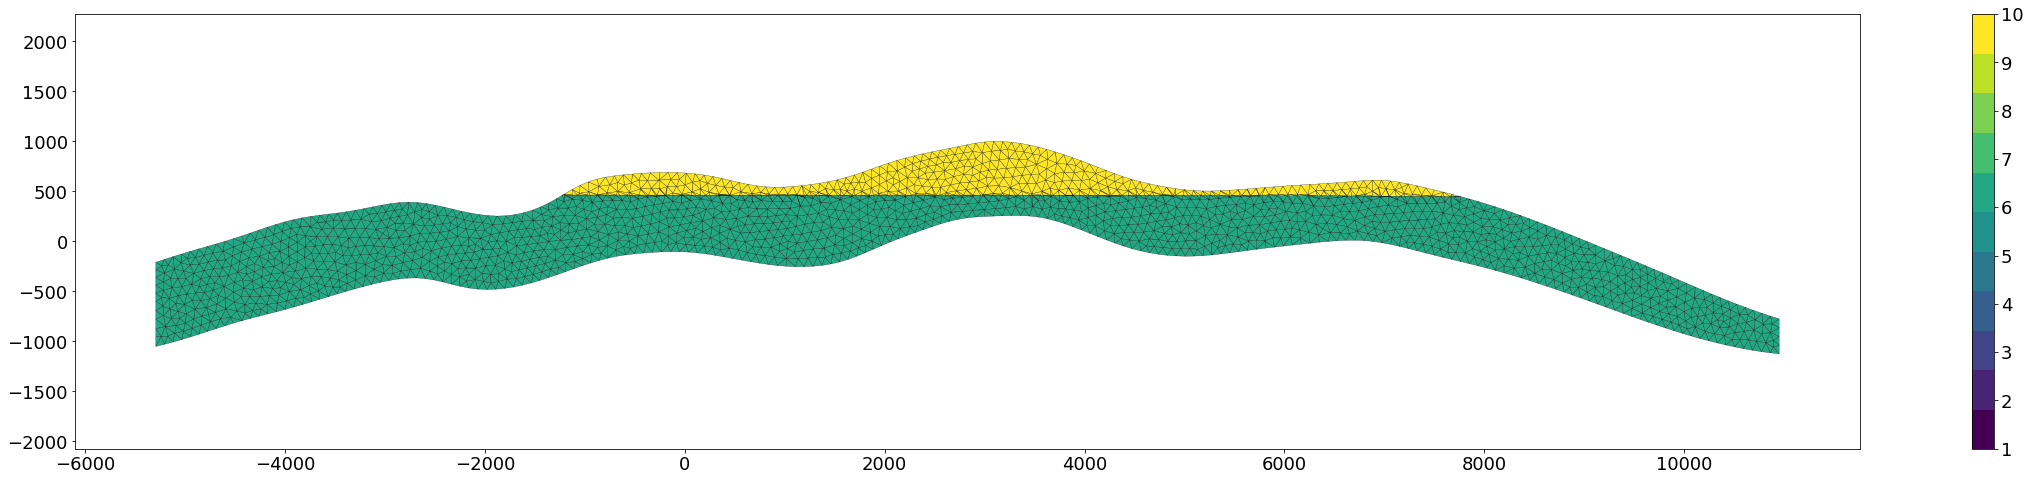

In [11]:
cut_region_path_vtk = path + "/data_paper/"+ my_mesh + "_reg_cut.vtk"

mmg2d([mmg_path, "-nomove", "-noinsert", "-noswap",
           filepath_to_write_cut, cut_region_path_vtk])

m = meshio.Mesh.read(cut_region_path_vtk, "vtk")
f=plt.figure(figsize=(40,8))   
a0 = plt.subplot(111)
a0.axis('equal')
a0.set_ylim((-1000, 1200))

x,y,Triangles=m.points[:,0],m.points[:,1],m.cells_dict['triangle']
region=m.cell_data['medit:ref'][1]
cm=plt.tripcolor(x,y, Triangles,facecolors=region,edgecolor="black", cmap=cmap)       
   
plt.colorbar(cm)
plt.clim(1,10)

### Mark boundary edges to keep the mesh conformity

In [12]:
filepath_to_write_cut_req = path + "/data_paper/"+ my_mesh + "_reg_cut_req.mesh"
write_2D_mesh_file(filepath_to_write_cut, filepath_to_write_cut_req)

ok
else


### Remeshing in the modified region

WRITING COMPLETED
WRITING COMPLETED


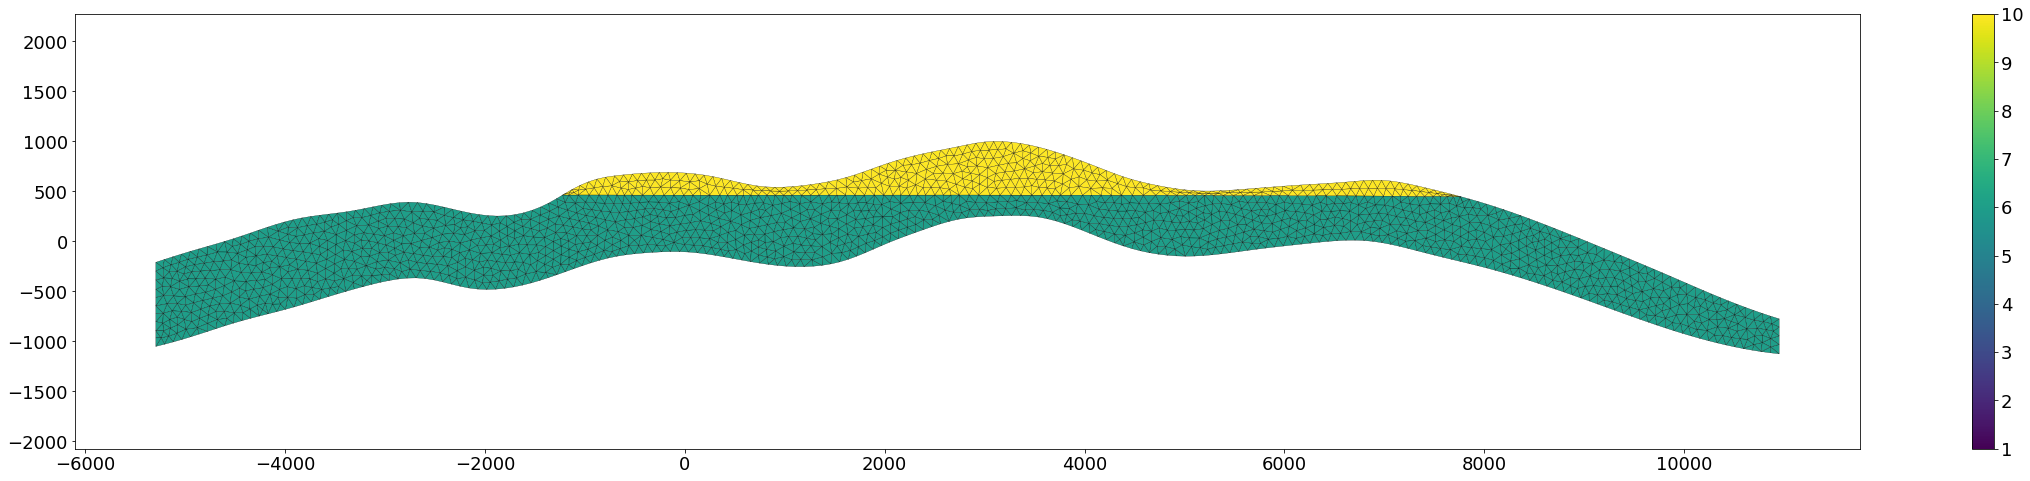

In [13]:
mmg2d([mmg_path, "-hmin", "90","-hmax", "90",
           filepath_to_write_cut_req])

output_remeshed=path + "/data_paper/"+ my_mesh + "_reg_cut_req.o.mesh"
output_remeshed_vtk=path + "/data_paper/"+ my_mesh + "_reg_cut_req.o.vtk"

mmg2d([mmg_path, "-nomove", "-noinsert", "-noswap",
           output_remeshed, output_remeshed_vtk])

m = meshio.Mesh.read(output_remeshed_vtk, "vtk")
f=plt.figure(figsize=(40,8))   
a0 = plt.subplot(111)
a0.axis('equal')
a0.set_ylim((-1000, 1200))

x,y,Triangles=m.points[:,0],m.points[:,1],m.cells_dict['triangle']
region=m.cell_data['medit:ref'][1]
cm=plt.tripcolor(x,y, Triangles,facecolors=region,edgecolor="black")       
   
plt.colorbar(cm)
plt.clim(1,10)

## Result of th local modification

merge ok
ok
corners
required
WRITING COMPLETED


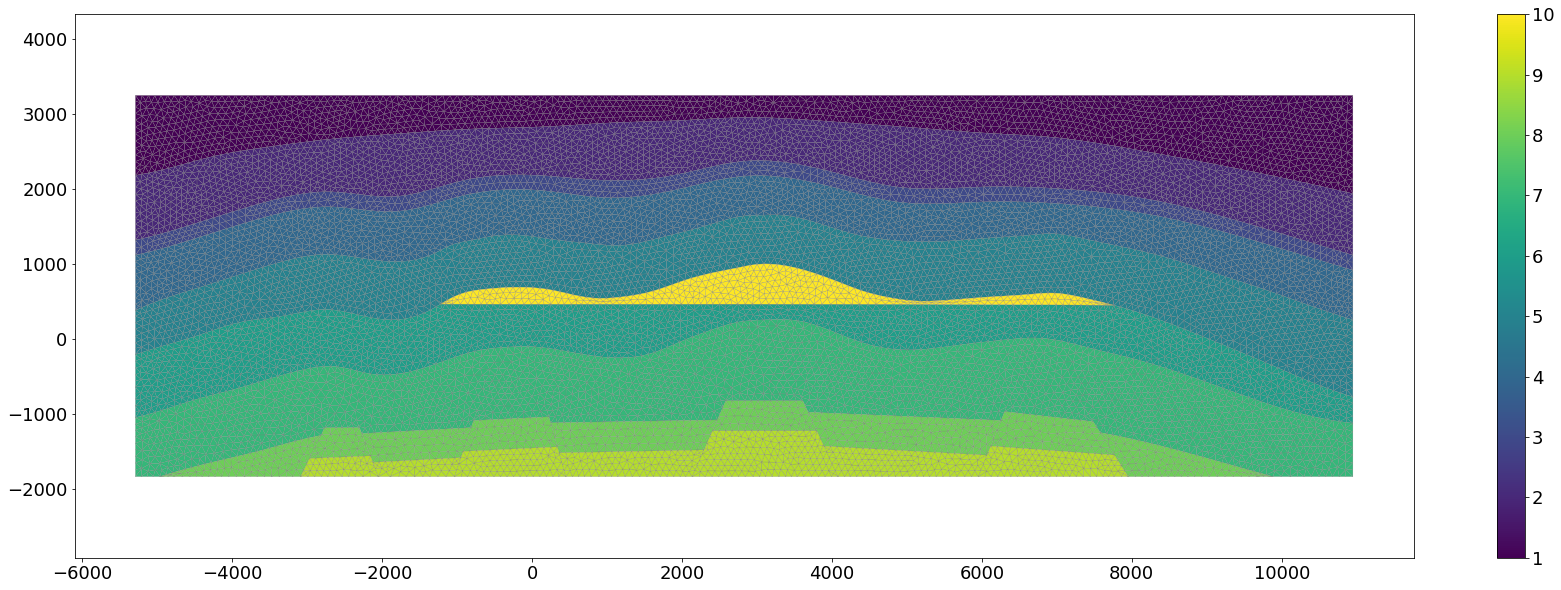

In [14]:
filepath_mesh_merge = path + "/data_paper/" + "mesh_merge.mesh"
filepath_final_mesh = path + "/data_paper/" + "output_mesh.mesh"
filepath_final_mesh_vtk= path + "/data_paper/" + "output_mesh.vtk"

merge(output_remeshed, filepath_to_write_other, filepath_mesh_merge)
print("merge ok")
write_2D_mesh_file_gmsh(filepath_mesh_merge, filepath_final_mesh)

mmg2d([mmg_path, "-nomove", "-noinsert", "-noswap",
           filepath_final_mesh, filepath_final_mesh_vtk])

m = meshio.Mesh.read(filepath_final_mesh_vtk, "vtk")
f=plt.figure(figsize=(30,10))   
a0 = plt.subplot(111)
a0.axis('equal')

x,y,Triangles=m.points[:,0],m.points[:,1],m.cells_dict['triangle']
region=m.cell_data['medit:ref'][1]
cm=plt.tripcolor(x,y, Triangles,facecolors=region,edgecolor="grey")     
plt.colorbar(cm)
plt.clim(1,10)   